# Simple 1D Kernel Density Estimation

- using Scikit-Learn.

### Reference:

- [Scikit-Learn documentation - Simple 1D Kernel Density Estimation](https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py)

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}
import math
import scipy.stats as stats
from scipy.signal import argrelextrema

## data

In [4]:
N = 1000
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

## Plot a 1D density

In [5]:
## estimate
def local_maximums_kde_gaussian(data:'array', threshold_freq:'float')->'array':
    ## histogram density estimation with kde 
    noise = data[~np.isnan(data)]
    density = stats.gaussian_kde(noise)
    n, x = np.histogram(noise, bins = 250 , density=True)
    ## local maxima (histogram peaks) estimation = steps values
    imaxi = argrelextrema(density(x), np.greater)
    # validate if all peaks are zero
    is_all_zeros = len(np.where(n[imaxi]<=threshold_freq)[0])==len(n[imaxi])
    if is_all_zeros: threshold_freq = -9999.
    # select peaks = steps values average
    steps_avg = x[imaxi[0][np.where(n[imaxi]>threshold_freq)[0]]]
    # return
    return steps_avg

## float to int truncating for possitive and negative values
def truncate(x:float)->int:
    return math.floor(x) if x<0 else math.ceil(x)


In [12]:
## plot histogram with KDE using different kernels
def histogram_kde(X, threshold_freq = 0.0001, nbins = None, figsize = (15,8), supply:bool = False)->tuple:
    
    # estimate x limits
    add = truncate(np.ptp(X)) * 0.5 / 10.
    xmin = truncate(np.min(X)) - add if truncate(np.min(X)) < 0 else truncate(np.min(X)) + add
    xmax = truncate(np.max(X)) - add if truncate(np.max(X)) < 0 else truncate(np.max(X)) + add

    # estimate local maximum
    steps_avg = local_maximums_kde_gaussian(X.copy(), threshold_freq) 
    #print('local maximums (gaussian): %s'%steps_avg)

    # number of bins
    if nbins is None:
        R = truncate(np.ptp(X))
        n = len(X)
        sigma = np.nanstd(X)
        nbins = truncate(( R * (n**float(1/3)) ) / 3.49 * sigma )
    bins = np.linspace(truncate(np.min(X)), truncate(np.max(X)), nbins)

    # x for plot
    X_plot = np.linspace(truncate(np.min(X)), truncate(np.max(X)), 1000)[:, np.newaxis]

    # create fig/axes
    fig, ax = plt.subplots(figsize = figsize)
    # plot the input data distribution
    h_y, h_x, _ = ax.hist(X , density = True, bins = bins, color = 'grey', label = 'input distribution', alpha = 0.2)
    # settings
    colors = ['cornflowerblue', 'darkorange', 'navy']
    kernels = ['tophat', 'epanechnikov', 'gaussian']
    lw = 2
    # calculate kde and plot
    for color, kernel in zip(colors, kernels):
        kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
        log_dens = kde.score_samples(X_plot)
        ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
                linestyle='-', label="kernel = '{0}'".format(kernel))
        # store gaussian results
        if kernel == 'gaussian':
            l_y = np.exp(log_dens)
            l_x = X_plot[:, 0]
    # set legend
    ax.legend(loc='upper left')
    # plot points on the botton
    if len(X) < 10000:
        ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')
    # plot estimated local maximuns
    for avg in steps_avg:
        ax.axvline(avg, color='k', linestyle='--')
    # set chart limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-0.02, np.max(h_y) + 0.05)
    # set title
    ax.set_title("%s points / %s bins"%(len(X), nbins))
    # set labels
    ax.set_ylabel("freq")
    # display / return
    if supply:
        return ((h_x, h_y), (l_x, l_y), ax)
    else:
        plt.show()
        return ((h_x, h_y), (l_x, l_y))
    

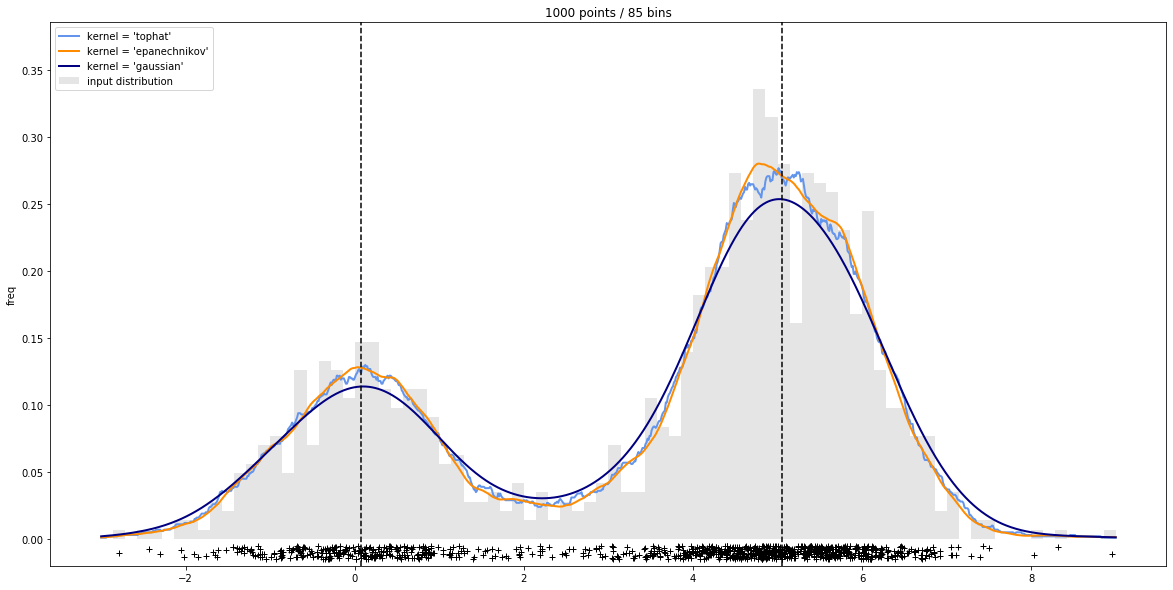

In [13]:
h, l = histogram_kde(X, figsize = (20,10))

###

### available kernels

Text(0.5, 1.0, 'Available Kernels')

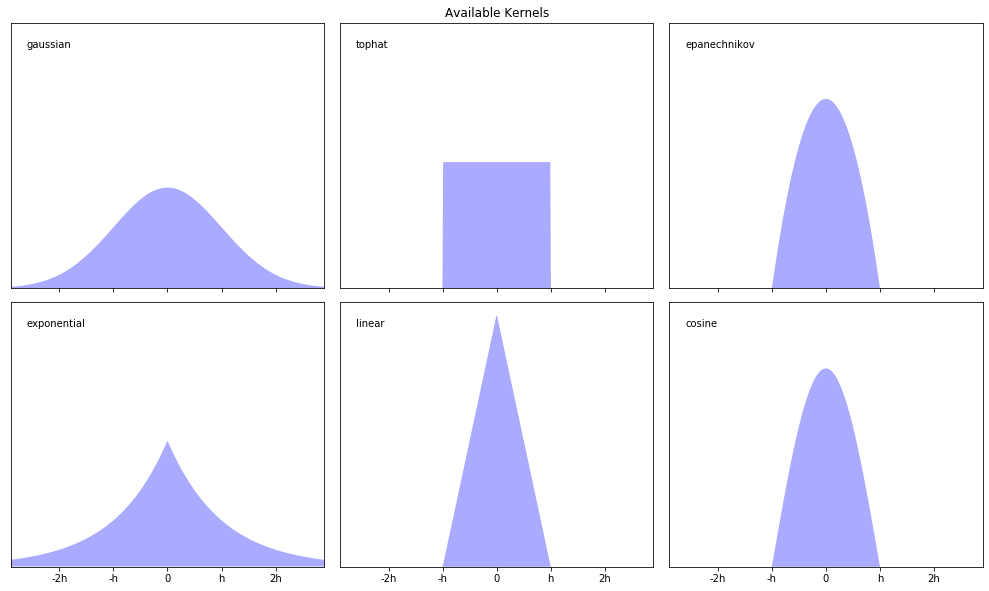

In [18]:
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (15,10))
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels')